<a href="https://www.kaggle.com/code/matteoanzano111/nba-viz-exploration-of-different-techniques?scriptVersionId=150962147" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# VISUALIZING IN BASKETBALL

The dataset offers statistics for basketball players during the initial 10 games of a season. Various charts will be presented to analyze player performance.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.impute import SimpleImputer
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nba-player-stats-dataset-for-the-2023-2024/NBA_2024_per_game(13-11-2023 Updated).csv
/kaggle/input/nba-player-stats-dataset-for-the-2023-2024/NBA_2024_per_game(15-11-2023 Updated).csv


In [2]:
df=pd.read_csv("/kaggle/input/nba-player-stats-dataset-for-the-2023-2024/NBA_2024_per_game(15-11-2023 Updated).csv")
df=df.loc[df.MP>5]


In [3]:
players=df.Player.value_counts()
traded_players=players[players>1].keys()

In [4]:
df=df.loc[(~df.Player.isin(traded_players)) | (df.Player.isin(traded_players) & df.Tm=='TOT')]

The most basic plot that we can create is an ordered bar plot, illustrating the top-performing players in each statistic.

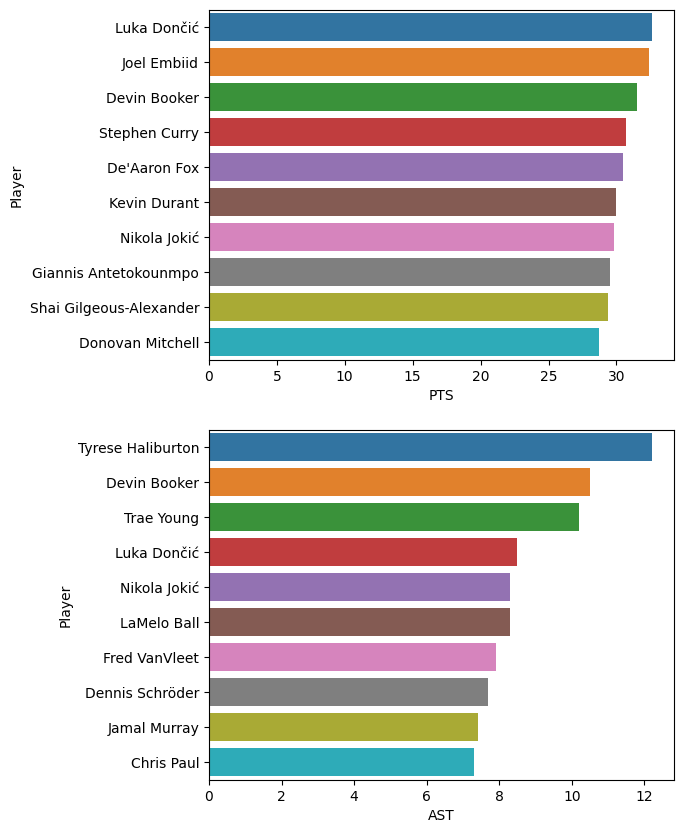

In [5]:
figure, axes = plt.subplots(2, 1, figsize=(6,10)) 
sns.barplot(ax=axes[0],x='PTS',y='Player', data=df.sort_values('PTS', ascending=False).iloc[0:10,:])
sns.barplot(ax=axes[1],x='AST',y='Player', data=df.sort_values('AST', ascending=False).iloc[0:10,:])
plt.show()

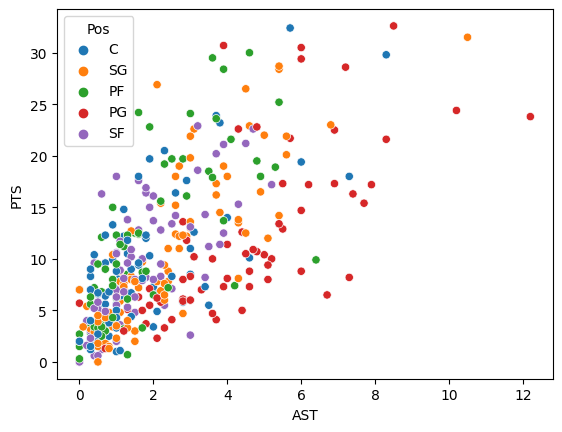

In [6]:
sns.scatterplot(y='PTS', x='AST', data=df, hue="Pos")
plt.show()

Along the y-axis, the players' position are uniform, indicating that no specific role outperforms others in terms of points. However, along the x-axis, we observe that the majority of players on the right, who contribute significantly to assists, are playmakers."

It's possible to analyze the relationships between variables through a correlation matrix. There is a slight positive correlation observed among all variables. Notably, *PTS* exhibits stronger correlations with *2P* and *FT*.

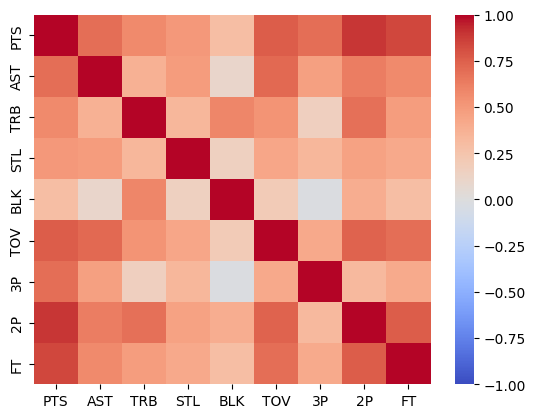

In [7]:
sns.heatmap(df[['PTS', 'AST', 'TRB', 'STL', 'BLK', 'TOV', '3P', '2P', 'FT']].corr(),cmap='coolwarm',vmin=-1, vmax=1)
plt.show()

# PCA decomposition

In the investigation of differences between basketball positions, relying solely on basic statistics like points and assists might not be the optimal approach. The reason is twofold: the abundance of statistics would necessitate numerous scatterplots, and at times, the distinctions between groups could be better elucidated by combinations of multiple statistics.

Through the application of *PCA* (Principal Component Analysis), it becomes feasible to amalgamate variables and generate new components that encapsulate multifaceted aspects of player performance.


Before performing *PCA*, standardizing the data is a recommended step to ensure comparability among variables.

In [8]:
df=df.loc[~df['eFG%'].isna()]
X=df[['PTS', 'AST', 'TRB', 'STL', 'BLK', 'TOV', '3P', '2P', 'FT']].div(df['MP'], axis=0)*36
scaler=StandardScaler()
X1 = scaler.fit_transform(X)

We choose to extract three components, that explain  28.6 + 20.5 + 14.5 = 63.1% of the variance of the variables

In [9]:
pca_2d = PCA(n_components=3)
PCs_2d = pd.DataFrame(pca_2d.fit_transform(X1))
PCs_2d.columns=["PC1", "PC2", 'PC3']
print("Explained_variance of PC1, PC2 and PC3 are ", np.round(pca_2d.explained_variance_ratio_[0],3), "and",np.round(pca_2d.explained_variance_ratio_[1],3),"and",np.round(pca_2d.explained_variance_ratio_[2],3))

Explained_variance of PC1, PC2 and PC3 are  0.298 and 0.203 and 0.134


In [10]:
loadings = pca_2d.components_.T * np.sqrt(pca_2d.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=X.columns)
loading_matrix

,PC1,PC2,PC3
PTS,0.867479,-0.280460,-0.316864
AST,0.476708,-0.323676,0.484220
TRB,0.310087,0.699241,-0.169419
STL,0.072477,0.014693,0.734805
BLK,0.091098,0.714120,-0.204113
TOV,0.641202,-0.090152,0.217652
3P,0.108234,-0.752866,-0.461635
2P,0.809861,0.271016,-0.022080
FT,0.720187,0.047839,-0.013605


First component describes players' scoring ability, so *PTS*, *2P* and *FT*. 

The second component describes perimetral player, who has low values of *3P*, but high values of *TRB* and *BLK*.

The third component describes good ball handlers, who have high values of *AST*, *STL* and  medium *TOV*

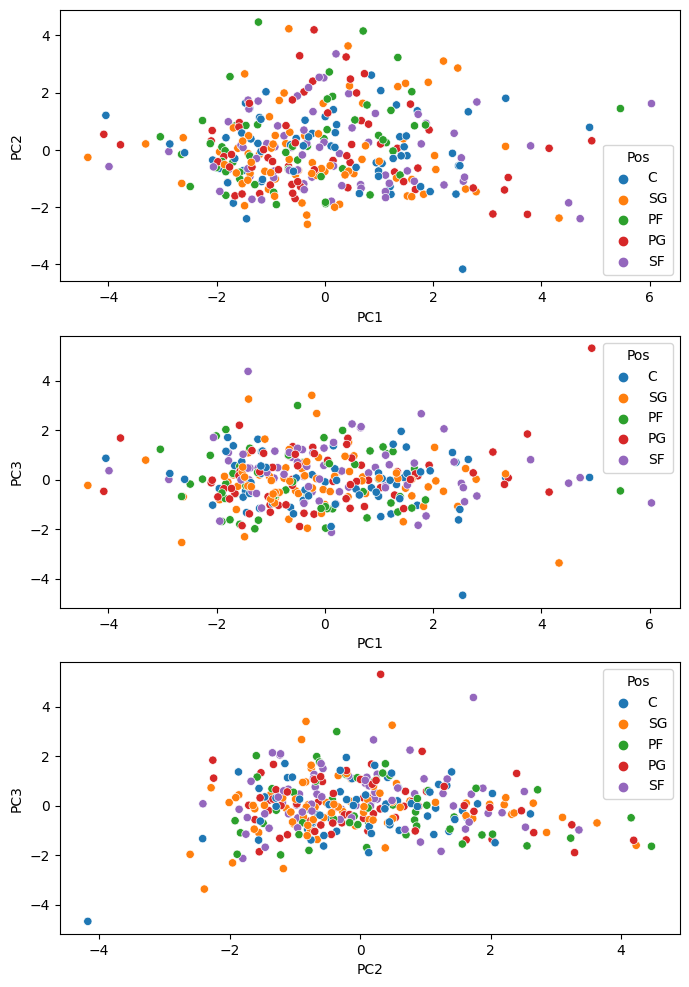

In [11]:
figure, axes = plt.subplots(3, 1, figsize=(8,12)) 
sns.scatterplot(ax=axes[0], y='PC2', x='PC1', data=PCs_2d, hue=df.Pos)
sns.scatterplot(ax=axes[1], y='PC3', x='PC1', data=PCs_2d, hue=df.Pos)
sns.scatterplot(ax=axes[2], y='PC3', x='PC2', data=PCs_2d, hue=df.Pos)
plt.show()

In the first graph, it's noticeable that *Centers* tend to have lower values of *PC2*, whereas *Shooting Guards* tend to have higher values of *PC2*. This aligns with the understanding that *PC2* characterizes perimeter players.

Additionally, the third graph reveals that many playmakers exhibit high values of *PC3*. However, it's essential to note that not all playmakers demonstrate elevated values of *PC3*, because *PC3* specifically delineates playmakers who do not frequently attempt three-point shots.

## Players Comparison

A potential approach for comparing players is by utilizing the five key basketball statistics, dividing them into *N* classes, and determining the class for each statistic for each player.

In this script, I've categorized them into five classes and presented a radar chart for making comparisons.

In [12]:
stats=df[['Player','PTS', 'AST', 'TRB','STL', 'BLK']]

In [13]:
stats.loc[:, 'PTS'] = pd.qcut(stats['PTS'], q=5, labels=False) + 1
stats.loc[:, 'AST'] = pd.qcut(stats['AST'], q=5, labels=False) + 1
stats.loc[:, 'TRB'] = pd.qcut(stats['TRB'], q=5, labels=False) + 1
stats.loc[:, 'STL'] = pd.qcut(stats['STL'], q=5, labels=False) + 1
stats.loc[:, 'BLK'] = pd.qcut(stats['BLK'], q=5, labels=False, duplicates='drop') + 1
stats.loc[stats.BLK>1, 'BLK'] = stats.loc[stats.BLK>1, 'BLK'] + 1
stats=pd.melt(stats, id_vars=['Player'], value_vars=['PTS', 'AST', 'TRB', 'STL', 'BLK'])


In the next graph are compared *Russel Westbrook* and *James Harden*.

In [14]:
players=['Russell Westbrook', 'James Harden']
stats_filtered=stats.loc[stats.Player.isin(players)]
fig = px.line_polar(stats_filtered, r='value', theta='variable', line_close=True,  color='Player',
        title='Radar Graph')
fig.show()

# Teams Comparison

The subsequent phase of the analysis involves examining the distribution of points and assists within each team.

The objective is to illustrate the level of balance within each team concerning points and assists. To achieve this, only the top 7 players from each team, based on playing minutes, were considered. The Gini index for points and assists was computed for each team.

The Gini index is a statistic ranging from 0 to 1. A value of 0 signifies a perfectly balanced distribution of the statistic among players, whereas a value of 1 indicates a distribution entirely concentrated in a single player.

In [15]:
df_sorted = df.sort_values(by=['MP'], ascending=False)

# Define a function to get the top 7 players for each team
def top_players(group):
    return group.head(7)

df_top_players = df_sorted.groupby('Tm').apply(top_players).reset_index(drop=True)


In [16]:
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

In [17]:
points_gini = df_top_players.groupby('Tm')['PTS'].apply(lambda x: gini(x))
ast_gini = df_top_players.groupby('Tm')['AST'].apply(lambda x: gini(x))

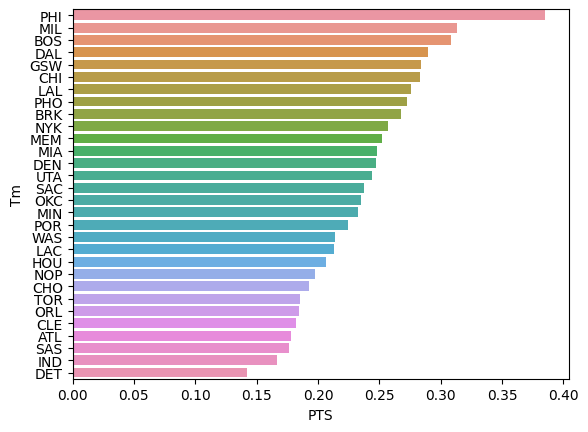

In [18]:
points_gini_sorted = points_gini.sort_values(ascending=False)
sns.barplot(x=points_gini_sorted, y=points_gini_sorted.keys())
plt.show()

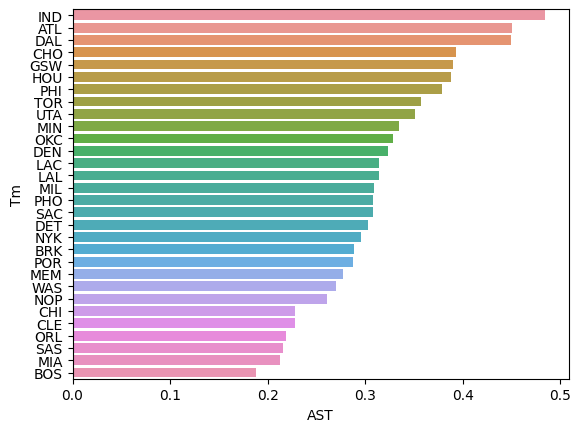

In [19]:
ast_gini_sorted = ast_gini.sort_values(ascending=False)
sns.barplot(x=ast_gini_sorted, y=ast_gini_sorted.keys())
plt.show()

We observe that the teams with less equally distributed points are *PHI*, *BOS*, and *CHI*, while the most balanced teams in terms of points are *DET*, *ATL*, and *IND*. The teams with the least balanced distribution in assists are *IND*, *DAL* , and *IND*, while those with the most balanced assists are *BRK*, *BOS*, and *ORL*.


Concentration of *PTS* and *AST* seems to be uncorrelated. The correlation between them is -0.03.

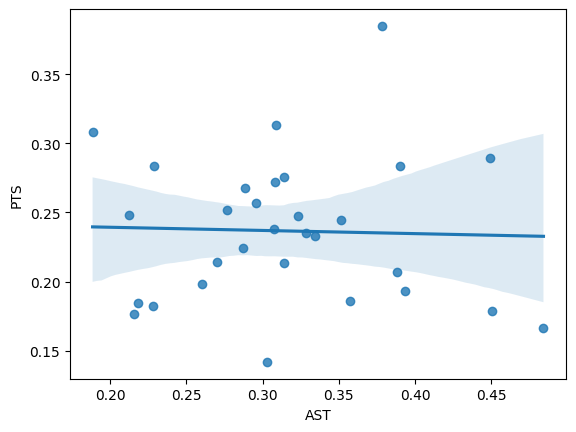

In [20]:
sns.regplot(x=ast_gini, y=points_gini)
plt.show()

In [21]:
np.corrcoef(ast_gini,points_gini)

array([[ 1.        , -0.03258641],
       [-0.03258641,  1.        ]])